In [7]:
#Loading libraries used for this project
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import partial_dependence
%matplotlib inline
import matplotlib.pyplot as plt

Reading the data below

In [56]:
data = pd.read_csv('conversion_data.csv')

In [57]:
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


Describing basic summary statistics

In [10]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Some quick observations
1. The users for this site is fairly young with a mean age of about 30 years.
2. There seems to be some data inconsistency. The maximum age is indicated to be 123 years.
3. 68% of the users are new and only less that 32% are return users.
4. The average number of pages visited by a user in one session is around 4.8 pages.
5. Total number of users that convert is around 3% which seems reasonable as it is the industry standard.

In [11]:
#investigating country and source columns
data['country'].describe()

count     316200
unique         4
top           US
freq      178092
Name: country, dtype: object

In [12]:
data['source'].describe()

count     316200
unique         3
top          Seo
freq      155040
Name: source, dtype: object

In [14]:
data.groupby('country').count()

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,76602,76602,76602,76602,76602
Germany,13056,13056,13056,13056,13056
UK,48450,48450,48450,48450,48450
US,178092,178092,178092,178092,178092


Highest traffic for the site comes from US, followed by China and UK. This indicates it's probably a US based site.

Checking for data inconsistencies below

In [15]:
data.sort_values(by = 'age', ascending = False).head(10)

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
301366,UK,70,0,Ads,5,0
114485,US,70,1,Ads,9,0
57122,UK,69,1,Direct,4,0
290142,US,69,1,Seo,6,0


It's evident that there are only two rows with probably wrong data entered.

The next course of action is one of two things

1. Remove both these rows
2. Fill these rows with a substituted value such as mean age etc

It's safer to remove the entire row

In [17]:
data.drop([90928,295581], axis = 0).sort_values(by = 'age', ascending = False).head(7)

,country,age,new_user,source,total_pages_visited,converted
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
114485,US,70,1,Ads,9,0
301366,UK,70,0,Ads,5,0
57122,UK,69,1,Direct,4,0


The inconsistent data points have been removed


Exploring the data below to get a better sense of it.

In [18]:
#Conversion rate by countries

data_country = data.groupby('country')[['converted']].mean()

In [19]:
#Plotting the above dataframe

data_country.head(5)

,converted
country,
China,0.001332
Germany,0.062500
UK,0.052632
US,0.037801


<AxesSubplot:xlabel='country'>

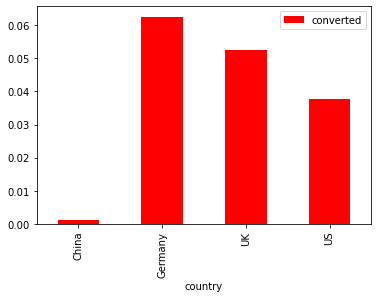

In [21]:
data_country.plot(kind = 'bar', color = 'r')

Some quick takeaways:

1. Although Germany seems to have the lowest traffic, it still seems to maintain the highest conversion rate.
This is true of UK as well.
2. However, it is interesting to note that, China has a very low conversion rate. Much lesser than the other three countries

Let's look into this further

Plotting total pages visited. This plot is as expected. As the number of pages visited increases, the conversion rate increases as well.

<AxesSubplot:xlabel='total_pages_visited'>

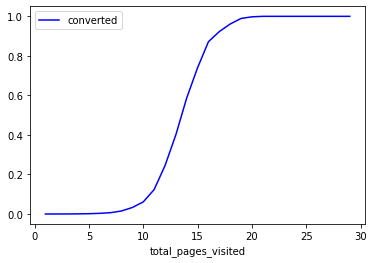

In [22]:
data.groupby('total_pages_visited')[['converted']].mean().plot(kind = 'line', color = 'b')

In [23]:
#Looking into China
#Mean age of chinese users
data.groupby('country')[['age']].describe()

age                                                    
            count       mean       std   min   25%   50%   75%    max
country                                                              
China     76602.0  30.672972  8.283862  17.0  24.0  30.0  36.0   69.0
Germany   13056.0  30.449985  8.289022  17.0  24.0  30.0  36.0  123.0
UK        48450.0  30.451538  8.244991  17.0  24.0  30.0  36.0  111.0
US       178092.0  30.566482  8.272128  17.0  24.0  30.0  36.0   79.0

Roughly the mean age of chinese users is on par with the mean age of users in other countries. Hence, this is probably not the cause for their low conversion.

In [24]:
#Number of pages visited by an average Chinese user
data.groupby('country').mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.449985,0.677237,5.190717,0.062500
UK,30.451538,0.679835,5.082167,0.052632
US,30.566482,0.681985,4.930160,0.037801


<AxesSubplot:xlabel='source,country'>

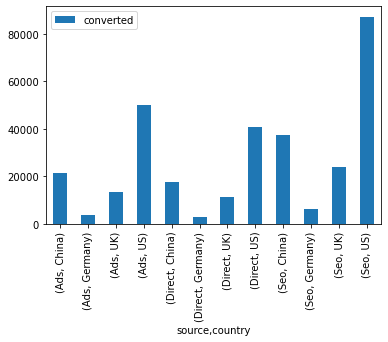

In [25]:
#Users' from ads
df_analysis = data.groupby(['source','country'])[['converted']].count()
df_analysis.plot(kind = 'bar')

<AxesSubplot:xlabel='source'>

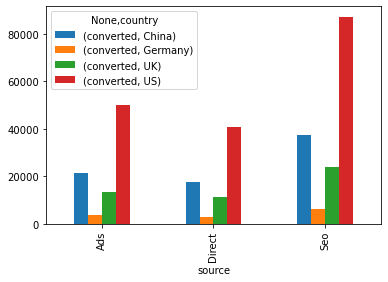

In [26]:
#Absolute numbers
df_analysis.unstack('country').plot(kind = 'bar')

In [27]:
#percentages
df_analysis.unstack('country')

converted                      
country     China Germany     UK     US
source                                 
Ads         21561    3760  13518  49901
Direct      17463    2864  11131  40962
Seo         37578    6432  23801  87229

In [28]:
def f(x):
    y = Series([0,0,0])
    for i in np.arange(3):
        y[i] = 100 * x[i]/sum(x)
    return y

df_analysis.unstack('country').apply(f, axis = 0)

converted                
country     China Germany  UK  US
0              28      28  27  28
1              22      21  22  23
2              49      49  49  48

<AxesSubplot:>

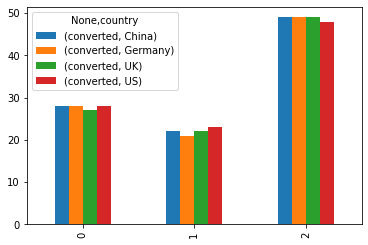

In [29]:
df_analysis.unstack('country').apply(f, axis = 0).plot(kind = 'bar')

From the above table, it is evident that the conversion from seo is maximum for all countries. Also, the distribution of ads, seo and direct is comparable for all countries.

We have eliminated all the obvious reasons why China might be converting poorly. From this analysis it can be said that, data from Chinese users is very similar to the ones from other users.

We need to look into it even further.

Delving into Machine Learning

In [30]:
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [31]:
data.columns.values

array(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'], dtype=object)

In [32]:
#The response variable
y = data['converted']
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

In [33]:
#The features
X = data[data.columns.values[:-1]]
X.head(5)

,country,age,new_user,source,total_pages_visited
0,UK,25,1,Ads,1
1,US,23,1,Seo,5
2,US,28,1,Seo,4
3,China,39,1,Seo,5
4,US,30,1,Seo,6


In [34]:
#creating labels for country and source in the features data
lb = LabelEncoder()
X['country'] = lb.fit_transform(X['country'])
X['source'] = lb.fit_transform(X['source'])
X.head(5)

,country,age,new_user,source,total_pages_visited
0,2,25,1,0,1
1,3,23,1,2,5
2,3,28,1,2,4
3,0,39,1,2,5
4,3,30,1,2,6


Creating training and testing samples

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Creating an instance of the estimator

In [36]:
pipeline = Pipeline(steps = [('clf', DecisionTreeClassifier(criterion = 'entropy'))])

Defining the hyperparameters for the grid search

In [37]:
parameters = [{
        'clf__max_depth': (150, 155, 160),
        'clf__min_samples_split': (1,2,3),
        'clf__min_samples_leaf': (1,2,3)
    }]

Employing gridsearchcv

In [38]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs= -1, error_score= 0)

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(error_score=0,
             estimator=Pipeline(steps=[('clf',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             n_jobs=-1,
             param_grid=[{'clf__max_depth': (150, 155, 160),
                          'clf__min_samples_leaf': (1, 2, 3),
                          'clf__min_samples_split': (1, 2, 3)}])

Best parameters are as follows

In [40]:
best_parameters = grid_search.best_estimator_.get_params()
best_parameters

{'memory': None,
 'steps': [('clf',
   DecisionTreeClassifier(criterion='entropy', max_depth=160, min_samples_leaf=3))],
 'verbose': False,
 'clf': DecisionTreeClassifier(criterion='entropy', max_depth=160, min_samples_leaf=3),
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': None,
 'clf__criterion': 'entropy',
 'clf__max_depth': 160,
 'clf__max_features': None,
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__random_state': None,
 'clf__splitter': 'best'}

In [41]:
grid_search.best_params_

{'clf__max_depth': 160,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2}

Predicting conversion rate

In [43]:
preds = grid_search.predict(X_test)
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76457
           1       0.82      0.65      0.72      2593

    accuracy                           0.98     79050
   macro avg       0.90      0.82      0.86     79050
weighted avg       0.98      0.98      0.98     79050



Note

Recall = sensitivity = TP/(TP + FN)

Precision = TP/(TP + FP)

Specificity = TN/(TN + FP)

1. From the above results we can conclude, recall = 0.65 and precision = 0.83
2. This implies of all people who converted, we weren't able to identify 35% of them
3. Similarly of all the people we identified would convert only 83% of them actually converted

We need to improve sensitivity further

Using Ensemble Methods

In [44]:
pipeline = Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])

In [45]:
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,
                                    min_samples_split= 3, oob_score= True)

In [46]:
clf_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=20, oob_score=True)

In [47]:
preds = clf_forest.predict(X_test)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76457
           1       0.83      0.67      0.74      2593

    accuracy                           0.98     79050
   macro avg       0.91      0.83      0.87     79050
weighted avg       0.98      0.98      0.98     79050



Precision has remained the same. Sensitivity has improved by 3%

Understanding the important variables

In [49]:
clf_forest.feature_importances_

array([0.05535023, 0.08643046, 0.07333555, 0.01159229, 0.77329146])

Features used are

In [50]:
data.columns.values[:-1]

array(['country', 'age', 'new_user', 'source', 'total_pages_visited'],
      dtype=object)

In [51]:
clf_forest.oob_score_

0.9854986295593506

Some insights:
    
From variable importance, it can be said that, total_pages_visited is the most important feature. Also from oob score it can be said that oob error rate is close to 1.4%.

Out of box score is 98.5%. This implies, the predictions were right for 98.5% of the data set. However, it is useful to recognize that the dataset is highly imbalanced with 97% of the data in class 0 and only 3% in class 1. This implies, even if we had classified everything as 0, the accuracy would still be 97%. Therefore, our predictions have only improved by 1.5% which is the difference of 98.5% and 97%.

The real challenge lies in improving the recall value of class 1. This value is close to 70%. This implies 30% of the customers who converted were not recognized by our system as potential customers.

Recall value needs to be improved even if that results in an increased overall error rate (decrease in precision) and a decrease in specificity value.

Building RandomForest again. This time without the total pages visited feature. Also since, the classes are heavily imbalanced, giving it weights.

In [55]:
X_new_train = X_train.copy()
X_new_test = X_test.copy()

In [58]:
X_new_train = X_new_train.drop('total_pages_visited', axis = 1)
X_new_test = X_new_test.drop('total_pages_visited', axis = 1)

In [59]:
clf_forest_new = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 150, min_samples_leaf= 2,
                                    min_samples_split= 2, oob_score= True, class_weight = {0: 0.1, 1: 0.9})

In [60]:
clf_forest_new.fit(X_new_train, y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, criterion='entropy',
                       max_depth=150, min_samples_leaf=2, n_estimators=20,
                       oob_score=True)

In [61]:
preds = clf_forest_new.predict(X_new_test)
preds

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [62]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     76457
           1       0.15      0.40      0.21      2593

    accuracy                           0.90     79050
   macro avg       0.56      0.66      0.58     79050
weighted avg       0.95      0.90      0.92     79050



In [63]:
clf_forest_new.feature_importances_

array([0.33476518, 0.24604732, 0.39892694, 0.02026057])

In [64]:
X_new_train.columns.values

array(['country', 'age', 'new_user', 'source'], dtype=object)

Although the error rate has gone up and the recall value has significantly crashed, from variable importance, we can gather that new_user followed by country and age are the important variables with source having no effect on the outcome at all.

Conclusions:

It is possible to predict upto 98.5% accuracy or an out of bag error rate of 1.5%.

Some of the important features are

1. Number of pages visited
2. new_user
3. country
4. age

Site is working very well for Germany and not so well for China.

This could be because of various reasons such as poor translation or the chineese site might be in English as well.

The site works well for younger people. Those less than 30 years of age. It could either be because of the nature of the site that caters only to young people or it could be possible that older people find it difficult to navigate through the site for a meaningful conversion.

Also, since the most important feature here is the number of pages visited, it implies that, if someone who has visited a lot of pages hasn't converted, then there is a good chance that the user will convert with a little bit of marketing such as discounts, benefits etc.

Also, users with an old account tend to do better than the ones with a new account. This could be used by marketing team to it's advantage.